##  Project 5 Vehicle Detection and Tracking


In [13]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline

In [14]:
# # # the code in 28. Color Classify
# # # https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/be308636-742b-416a-8fcc-c6071865a11f

# # Define a function to compute binned color features  
# def bin_spatial(img, size=(32, 32)):
#     # Use cv2.resize().ravel() to create the feature vector


In [15]:
### TODO: Tweak these parameters and see how the results change.
#color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#color_space = 'HSV'
color_space = 'HLS'

orient = 9  # HOG orientations

pix_per_cell = 8 # HOG pixels per cell
pix_per_cell = 4 # HOG pixels per cell

cell_per_block = 2 # HOG cells per block

hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
spatial_size = (16, 16) # Spatial binning dimensions

#hist_bins = 16    # Number of histogram bins
hist_bins = 16    # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


In [16]:
# # lecture 32. sliding window implementation.
# # https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/8e39c07e-afd5-4ba5-9204-8b44aa39285c

# # Here is your draw_boxes function from the previous exercise
# def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
#     # Make a copy of the image


In [17]:
from tool_functions import *

start_time = time.time()

# # Read in cars and notcars
# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

# todo: remove this!!!!!!!
debug = 1
# Read in car and non-car images
cars = []
notcars = []
car_images = glob.glob('training_set/vehicles/GTI_MiddleClose/*.png')
for image in car_images:
    cars.append(image)
if 0 == debug:
    car_images = glob.glob('training_set/vehicles/GTI_Left/*.png')
    for image in car_images:
        cars.append(image)
    car_images = glob.glob('training_set/vehicles/GTI_Right/*.png')
    for image in car_images:
        cars.append(image)
    car_images = glob.glob('training_set/vehicles/GTI_Far/*.png')
    for image in car_images:
        cars.append(image)
    car_images = glob.glob('training_set/vehicles/KITTI_extracted/*.png')
    for image in car_images:
        cars.append(image)
    
notcar_images = glob.glob('training_set/non-vehicles/GTI/*.png')
for image in notcar_images:
    notcars.append(image)
if 0 == debug:
    notcar_images = glob.glob('training_set/non-vehicles/Extras/*.png')
    for image in notcar_images:
        notcars.append(image)
   
    
# todo: remove this!!!!!!!
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
if 1 == debug:
    sample_size = 500
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

print('cars size : ', len(cars))
print('notcars size : ', len(notcars))

elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel
#                                , spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
                               )

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel
#                                   , spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
                                  )
print('car_features shape:, ', len(car_features) )

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print('X:, ', X.shape, ' X_scaler: ', X_scaler)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )


cell passed.
cars size :  419
notcars size :  500
elapsed_time :  0.01144552230834961


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car_features shape:,  419
X:,  (919, 25116)  X_scaler:  StandardScaler(copy=True, with_mean=True, with_std=True)
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 25116
0.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9837
elapsed_time :  14.29987359046936


elapsed_time :  0.03701066970825195


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


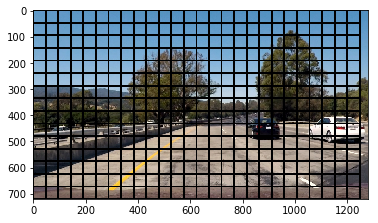

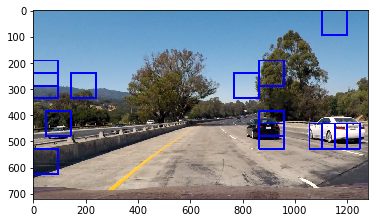

elapsed_time :  6.131340742111206
cell passed.


In [18]:
import time
start_time = time.time()

image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(48, 48), xy_overlap=(0.5, 0.5))

elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel
                        ,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
                            )

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )

print('cell passed.')

/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


cell passed.


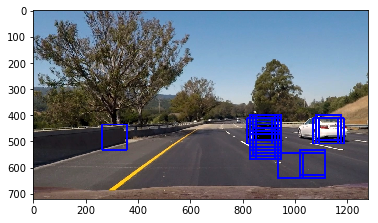

In [19]:
# example code from lecture 35. Hog Sub-sampling window search:
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/c3e815c7-1794-4854-8842-5d7b96276642

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # array of rectangles where cars were detected
    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
# todo: window, cells_per_step, should not be hard coded?
# should edit code refer to this discussion: 
# https://discussions.udacity.com/t/hog-sub-sampling-window-search/235413/30?u=sun.pochin
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, rectangles
    
ystart = 400
ystop = 656
scale = 1.5
    
img = mpimg.imread('test_images/test6.jpg')
out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                          pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)


print('cell passed.')

In [20]:
heatmap_threshold = 1

def add_heat(heatmap, bbox_list):
    print('bbox_list len: ', len(bbox_list) )
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Read in the last image above
img = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(img[:,:,0]).astype(np.float)

heat = add_heat(heatmap, rect)

from scipy.ndimage.measurements import label
labels = label(heat)
heat = apply_threshold(heat, heatmap_threshold)
labels = label(heat)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img





# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.imshow(draw_img)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


NameError: name 'heatmap' is not defined

In [ ]:

interrupt


In [ ]:
def process_one_image(img, debug = False):
    out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    return out_img

def process_image(image, debug = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # turn on debug to produce some image, for debugging or the writeups.
    # debug = True
    return process_one_image(image)


In [ ]:
# make sure the output folder exist.
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputdir = 'test_videos_output'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
white_output = outputdir + '/project-output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(26, 30)
#clip1 = VideoFileClip("project_video.mp4").subclip(39,43)
#clip1 = VideoFileClip("project_video.mp4")

#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


